In [1]:
import numpy as np
import pbdlib as pbd
import matplotlib.pyplot as plt
import tf_oc as oc
from IPython.core import display
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

demos.py -f policy_001 -p $HOME/code/MEMMO/policy_learning/data/tests/

3 without and with prior

5, 6, 7 without

In [70]:
data = np.load('../data/tests/policy_005.npy')[()]

In [71]:
x_in = np.concatenate(data['x'], axis=0)
x_out = np.concatenate(data['dx'], axis=0)
x_joint = np.concatenate([x_in, x_out], axis=1)
print x_in.shape, x_out.shape

(563, 2) (563, 2)


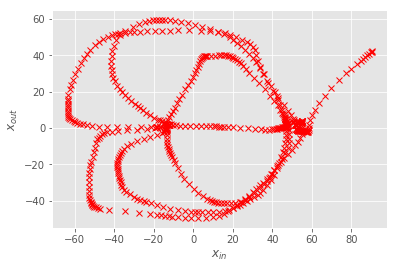

In [72]:
plt.plot(x_in[:, 0], x_in[:, 1], 'rx')
plt.xlabel(r'$x_{in}$')
plt.ylabel(r'$x_{out}$')

In [73]:
n_in = x_in.shape[1]
n_out = x_out.shape[1]
n_joint = x_joint.shape[1]
n_data = x_joint.shape[0]

### Covariance prior 

In [74]:
cov_tril = 40. * np.eye(4)
# cov_tril[2:4, :2] = -30. * np.eye(2)
cov_tril[2:4, :2] = 0. * np.eye(2)
cov = cov_tril.T.dot(cov_tril)
print cov

[[1600.    0.    0.    0.]
 [   0. 1600.    0.    0.]
 [   0.    0. 1600.    0.]
 [   0.    0.    0. 1600.]]


In [75]:
joint_model = pbd.VBayesianGMM({
        'n_components':25, 'n_init':3, 'reg_covar': 0.6 ** 2,
        'covariance_prior': cov, 'mean_precision_prior':20. ** -2,
        'weight_concentration_prior_type':'dirichlet_process', 'weight_concentration_prior': 1e3,
        'degrees_of_freedom_prior': n_joint - 1. + 1.3 })


In [76]:
joint_model.posterior(data=x_joint)

In [77]:
# fig, ax = plt.subplots(nrows=n_joint-1, ncols=n_joint-1, figsize=(10, 10))

# for i in range(n_joint):
#     for j in range(n_joint):
#         if not i == j and j>i:
#             ax[i][j-1].plot(x_joint[:, i], x_joint[:, j], 'kx')
#             joint_model.plot(dim=[i, j], ax=ax[i][j-1], alpha=0.2)

In [78]:
def f(x, use_gmr=False):
    if use_gmr:
        return gmr_model.condition(x, slice(0, n_in), slice(n_in, n_joint))[0]
    else:
        return joint_model.condition(x, slice(0, n_in), slice(n_in, n_joint))[0]

In [79]:
def uncertainty(x):
    return -np.log(joint_model.get_pred_post_uncertainty(x, slice(0, n_in), slice(n_in, n_joint)))

### Bayesian DP-GMM policy 

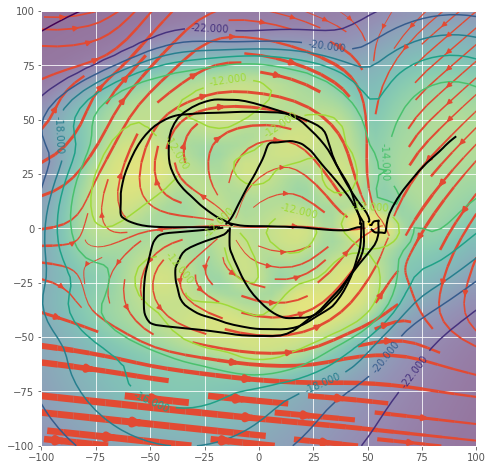

In [80]:
plt.figure(figsize=(8, 8))
pbd.plot_dynamic_system(f, xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.05)
pbd.plot_function_map(uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=80, opp=False)
# joint_model.plot(dim=[0, 1], alpha=0.1)
for d in data['x']:
    plt.plot(d[:, 0], d[:, 1], 'k', lw=2)

##  Converting to tensorflow model

In [81]:
sess = tf.InteractiveSession()

/home/pignate/anaconda2/lib/python2.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [82]:
tf_model = oc.stats.MTMMTril(*oc.stats.param_from_pbd(joint_model, student_t=True, tril=True))

In [83]:
sess.run(tf.global_variables_initializer())

In [84]:
x_eval = tf.placeholder(tf.float32, (None, 2))

In [85]:
logdets = np.linalg.slogdet(joint_model.sigma[:, 2:, 2:])[1]
max_logdet, min_logdet = np.max(logdets), np.min(logdets)

In [86]:
max_logdet

26.218712142132127

In [87]:
min_logdet

8.947206054218906

In [88]:
y = tf_model.condition(x_eval, slice(0, n_in), slice(n_in, n_joint), moment_matching=True)[0]
y_uncertainty = tf_model.get_posterior_det_cov(x_eval, slice(0, n_in), slice(n_in, n_joint))

y_uncertainty = tf.log((max_logdet - tf_model.get_posterior_det_cov(x_eval, slice(0, n_in), slice(n_in, n_joint)))/\
    (max_logdet-min_logdet))
    

In [89]:
def f_tf(x):
    return y.eval({x_eval: x})

def f_tf_uncertainty(x):
    return y_uncertainty.eval({x_eval: x})

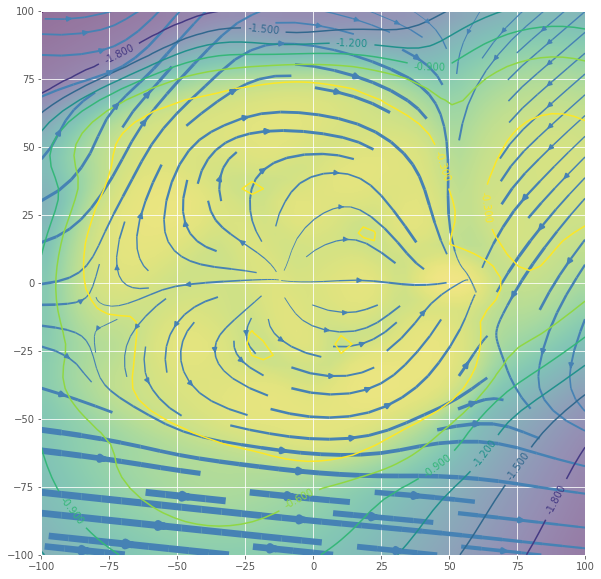

In [90]:
plt.figure(figsize=(10, 10))
pbd.plot_dynamic_system(f_tf, xlim=[-100, 100], ylim=[-100, 100], 
                        equal=True, scale=0.05, color='steelblue')

pbd.plot_function_map(f_tf_uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=20, 
                      opp=False)


In [91]:
grad = tf.gradients(y_uncertainty, x_eval)[0]

In [92]:
dt = 0.05

In [93]:
T = 20
A = lambda x: np.eye(3)
B = lambda x: dt * np.concatenate([np.eye(2), grad.eval({x_eval : [x]})])

In [94]:
lqr = pbd.LQR(A, B, horizon=T)
diag = lambda x: np.eye(x.shape[-1]) * x
cost_xi = pbd.GMM(nb_states=1, nb_dim=2)
cost_xi.mu = np.zeros((1, 3))
cost_xi.sigma = np.diag([1e10, 1e10, 1.])[None]

cost_u = pbd.MVN(nb_dim=2)

cost_u.mu = np.zeros(2)
cost_u.sigma = 4. * diag(np.cov(x_joint[:, :2], rowvar=False))

lqr.gmm_u = cost_u
lqr.gmm_xi = cost_xi, [0] * T

In [95]:
xi = lambda x: np.concatenate([x, y_uncertainty.eval({x_eval: [x]})], axis=0)

In [96]:
def stable_policy(x, t=0):
    _xi = xi(np.array(x))
    lqr.A, lqr.B = A(_xi[:2]), B(_xi[:2])
    lqr.ricatti()
    
    return lqr.K[0].dot(lqr.ds[0] - _xi), lqr.Q[t]

def stable_policy_vec(xs, t=0):
    loc, cov = zip(*[stable_policy(x) for x in xs])
    return np.array(loc), np.array(cov)

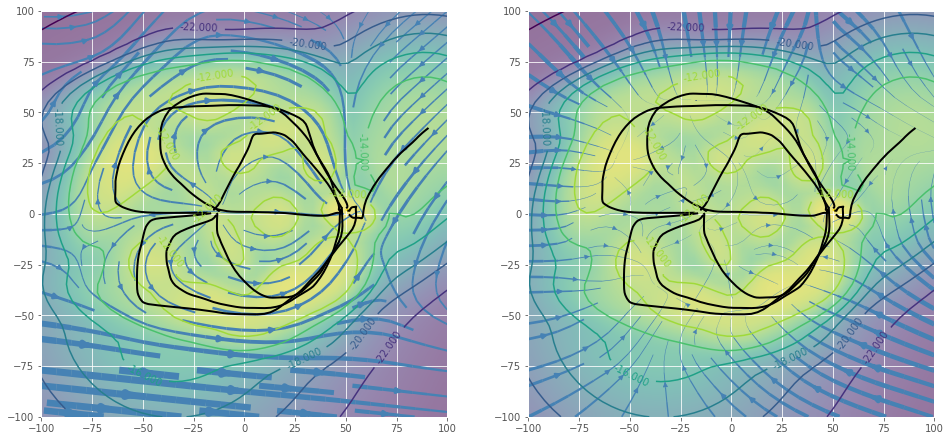

In [97]:
fig, ax= plt.subplots(ncols=2, figsize=(16, 8))

pbd.plot_dynamic_system(
    lambda x: f_tf(x),
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.05, ax=ax[0],
    color='steelblue'
)

pbd.plot_dynamic_system(
    lambda x: stable_policy_vec(x, t=0)[0],
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.05, ax=ax[1],
    color='steelblue'
)


for i in range(2):
    pbd.plot_function_map(
        uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False, ax=ax[i])

    for d in data['x']:
        ax[i].plot(d[:, 0], d[:, 1], 'k', lw=2)

        # ax[i].plot(xis[:, 0], xis[:, 1], lw=4, color='orangered')

In [98]:
def product_policy(x, t=0):
    mu_1, sigma_1 = joint_model.condition(x, slice(0, n_in), slice(n_in, n_joint))
    mu_2, sigma_2 = stable_policy_vec(x, t)
    
    lmbda_1, lmbda_2 = np.linalg.inv(sigma_1), np.linalg.inv(sigma_2) 
    lmbda_p = lmbda_1 + lmbda_2
    
    mu_p = np.einsum('aij,aj->ai',np.linalg.inv(lmbda_p),(np.einsum('aij,aj->ai', lmbda_1, mu_1) +
     np.einsum('aij,aj->ai', lmbda_2, mu_2)))
    return mu_p

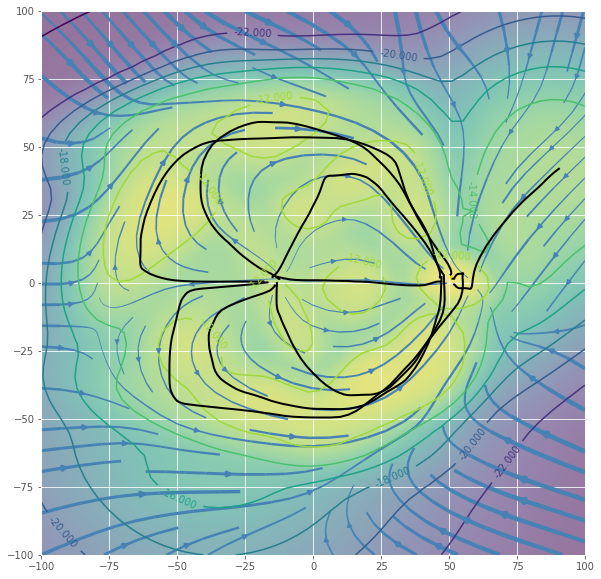

In [99]:
plt.figure(figsize=(10, 10))
pbd.plot_dynamic_system(
    lambda x: product_policy(x, t=0),
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.05,
    color='steelblue'
)

for d in data['x']:
    plt.plot(d[:, 0], d[:, 1], 'k', lw=2)
    
pbd.plot_function_map(
        uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False)

In [100]:
xis = [xi(np.array([-75, -25]))]

for i in range(250):
    _u = product_policy(xis[-1][:2][None])[0]
    
    _A, _B = A(xis[-1][:2]), B(xis[-1][:2])
    
    _xi = _A.dot(xis[-1]) + _B.dot(_u)
    
    xis += [xi(_xi[:2])]
    # _xi = 
    
xis = np.array(xis)

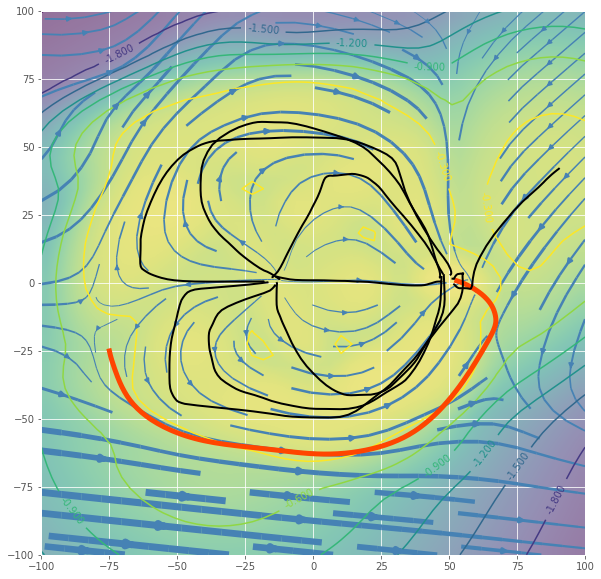

In [101]:
plt.figure(figsize=(10, 10))
pbd.plot_dynamic_system(f_tf, xlim=[-100, 100], ylim=[-100, 100], 
                        equal=True, scale=0.05, color='steelblue')

pbd.plot_function_map(f_tf_uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=20, 
                      opp=False)

plt.plot(xis[:, 0], xis[:, 1], color='orangered', lw=5)

for d in data['x']:
    plt.plot(d[:, 0], d[:, 1], 'k', lw=2)